In [23]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

import os.path
import numpy as np
import pandas as pd
from tensorboardX import SummaryWriter

from lib_for_dqn import lifecycle

env = lifecycle.LifecycleEnv()

check_env(env)

model = PPO("MlpPolicy", env, tensorboard_log="./runs/")

c:\Users\AS\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\Users\AS\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:287: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [24]:
if os.path.isfile("C:\\Users\\AS\\rep\\ucl_final_project\\reinforcement\\life.zip"):
    model = PPO.load("life", env=env)

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        value = np.random.random()
        self.logger.record('random_value', value)
        return True


model.learn(total_timesteps=1_000_000, callback=TensorboardCallback())
model.save("life")

In [25]:
# watch trained agent
state = env.reset()
done = False
rewards = 0
num_steps = env.terminal_age - env.starting_age + 1
info_df = pd.DataFrame(
    columns=("age", "start_wealth", "wealth", "consumption", "equity_allocation", "port_return"))

for step in range(num_steps):
    action, _states = model.predict(state, deterministic=True)
    new_state, reward, done, info = env.step(action)
    info_df = info_df.append(info, ignore_index=True) 
    rewards += reward
    state = new_state
print(rewards)

1621.4521417617798


Text(0.5, 1.0, 'Equity Allocation')

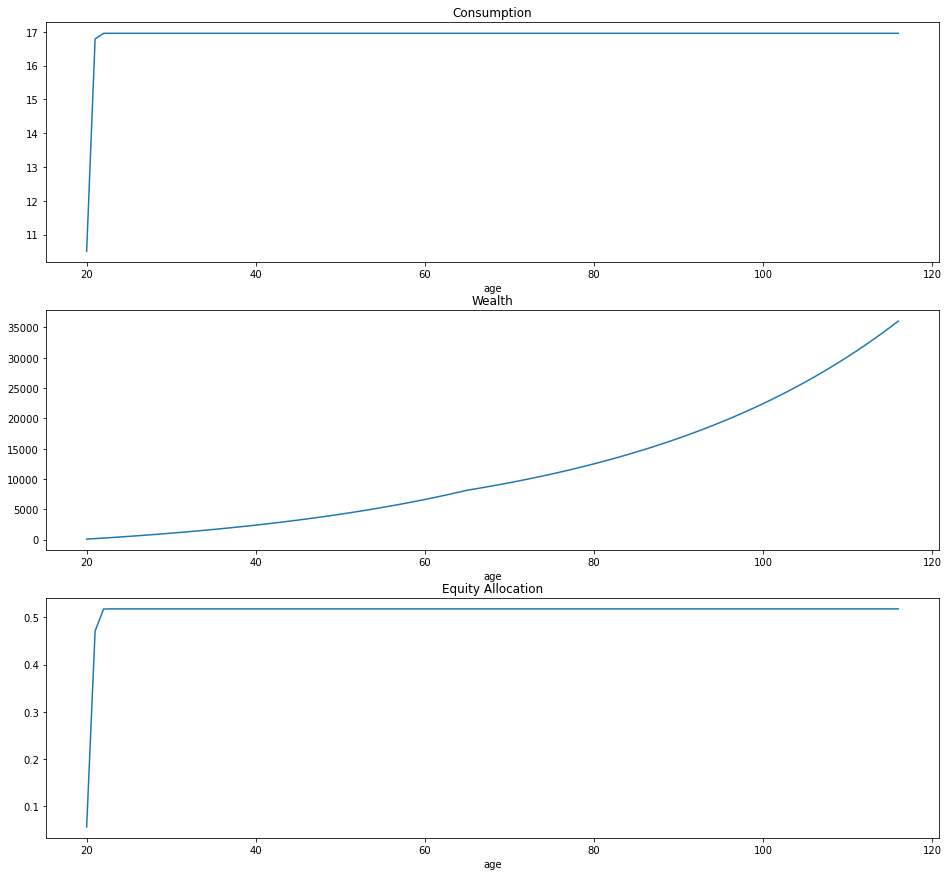

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 3, figsize=(16, 15))
info_df.set_index("age").consumption.rename("consumption").plot(ax = ax[0])
ax[0].set_title("Consumption")
info_df.set_index("age").wealth.plot(ax = ax[1])
ax[1].set_title("Wealth")
info_df.set_index("age").equity_allocation.plot(ax = ax[2])
ax[2].set_title("Equity Allocation")